In [2]:
# Authors: David Moiraf, david.moiraf@cea.fr
# Authors: Magne Lauritzen, mag.lauritzen@gmail.com

# -- use this line at the beginning of your notebook to turn on interactive plots
# %matplotlib notebook
%matplotlib widget

# Imports
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar

import seaborn as sns

from matplotlib.colors import Normalize

from core.sawtooth_extraction import ST_detector, ST_time_and_phase, ST_detector_plot
from core.pedestal_ploting import load_pedestal_data, scatter_pedestal_params, get_ELM_ST_phase_and_duration, scatter_pedestal_params_4plots, get_elm_length_and_time
from core.analysis import scatter_hist, load_ST_crash_time
from core.ELM_extraction import ELM_phase



psi_n_lim = 0.6
savesaw="/compass/home/odlozilik/repos/ELM-Sawtooth/sawtooth_data"
saveped="/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals"

In [3]:
pedestal_data_folder = Path('./shots_pedestals')
pedestal_data_list = []

for item in pedestal_data_folder.iterdir():
    if item.is_file and item.suffix == ".bin":
        with open(item, 'rb') as fp:
            pedestal_data_list.append(pickle.load(fp))

In [48]:
RMP_tot=np.empty(0)

ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

triangularity_val=np.empty(0)

ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)


for i, d in enumerate(pedestal_data_list):

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']

    RMP=shot(name="RMP_PS_1_Rogowski_coil_RAW")

    triang_closest_times = t_ELM_start[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    triang_closest_times_ints = triang_closest_times.astype(int)
    interpolated_tria_values = triangularity.interp(time=triang_closest_times_ints)
    
    interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)

        
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)

    

    RMP_tot = np.concatenate((RMP_tot,  interpolated_RMP_tot.to_numpy()[mask2]))
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))
    triangularity_val = np.concatenate((triangularity_val, interpolated_tria_values.to_numpy()[mask2]))


    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

    


In [62]:
#load the data
RMP_tot_ST=np.empty(0)

triangularity_val_ST=np.empty(0)

ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)


for i, d in enumerate(pedestal_data_list):
    # Filters
    shot = cdbxr.Shot(d.shot_number)
    ST_times = load_ST_crash_time(d.shot_number)

    RMP=shot(name="RMP_PS_1_Rogowski_coil_RAW")

    triang_closest_times = ST_times[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    triang_closest_times_ints = triang_closest_times.astype(int)
    interpolated_tria_values = triangularity.interp(time=triang_closest_times_ints)
    interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)


    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]


    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)


    RMP_tot_ST = np.concatenate((RMP_tot_ST,  interpolated_RMP_tot.to_numpy()[mask1]))
    triangularity_val_ST = np.concatenate((triangularity_val_ST, interpolated_tria_values.to_numpy()[mask1]))

    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

    


In [95]:
# Assuming you have ndarrays a, b, c, d, e
# Replace these with your actual data
a = ST_time_relative_to_ELM_tot
b = ST_periods_tot
d = triangularity_val_ST
e = RMP_tot_ST

# Create a DataFrame from the arrays
data = {'ST after ELM [ms]': a, 'T_ST [ms]': b, 'Triangularity': d}
df = pd.DataFrame(data)

In [117]:
# Assuming you have ndarrays a, b, c, d, e
# Replace these with your actual data
a = ELM_duration_tot
b = ELM_ST_time_tot
d = triangularity_val
e = RMP_tot

# Create a DataFrame from the arrays
data = {'T_ELM [ms]': a, 'ELM after ST  [ms]': b, 'Triangularity': d}
df = pd.DataFrame(data)

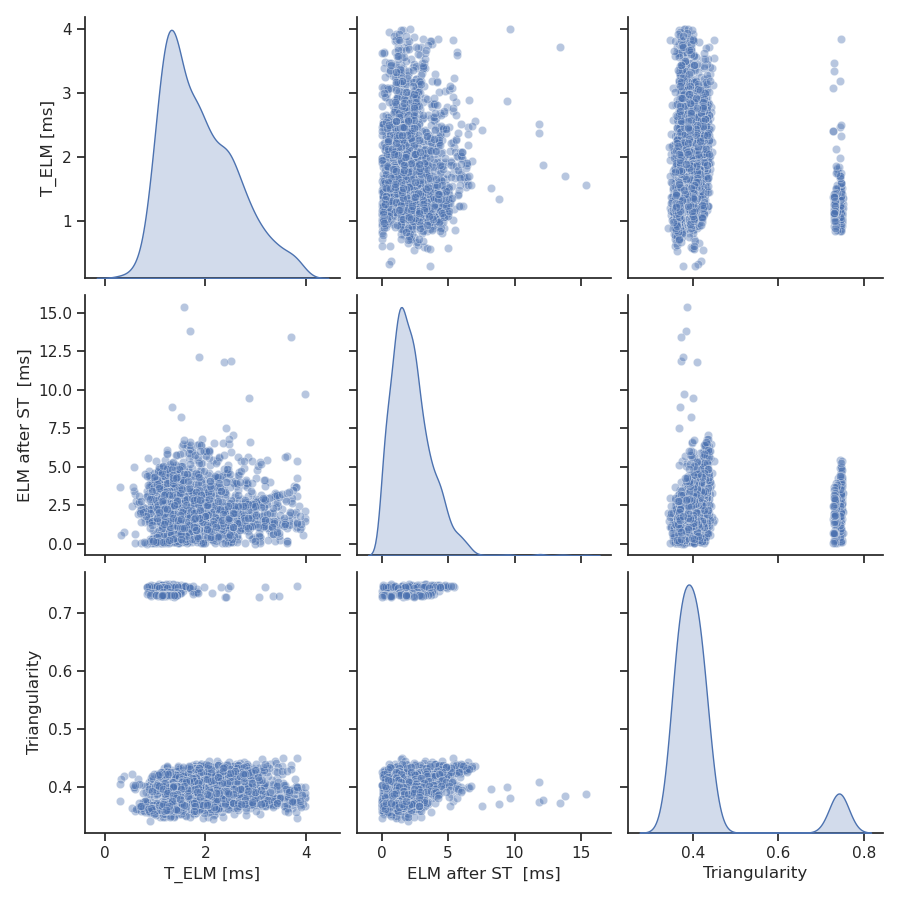

In [118]:
df = pd.DataFrame(data)
sns.set_theme(style="ticks")

sns.pairplot(df,kind="scatter",height=3, aspect=1,diag_kind='kde', plot_kws={'alpha': 0.4})
plt.tight_layout
plt.show()

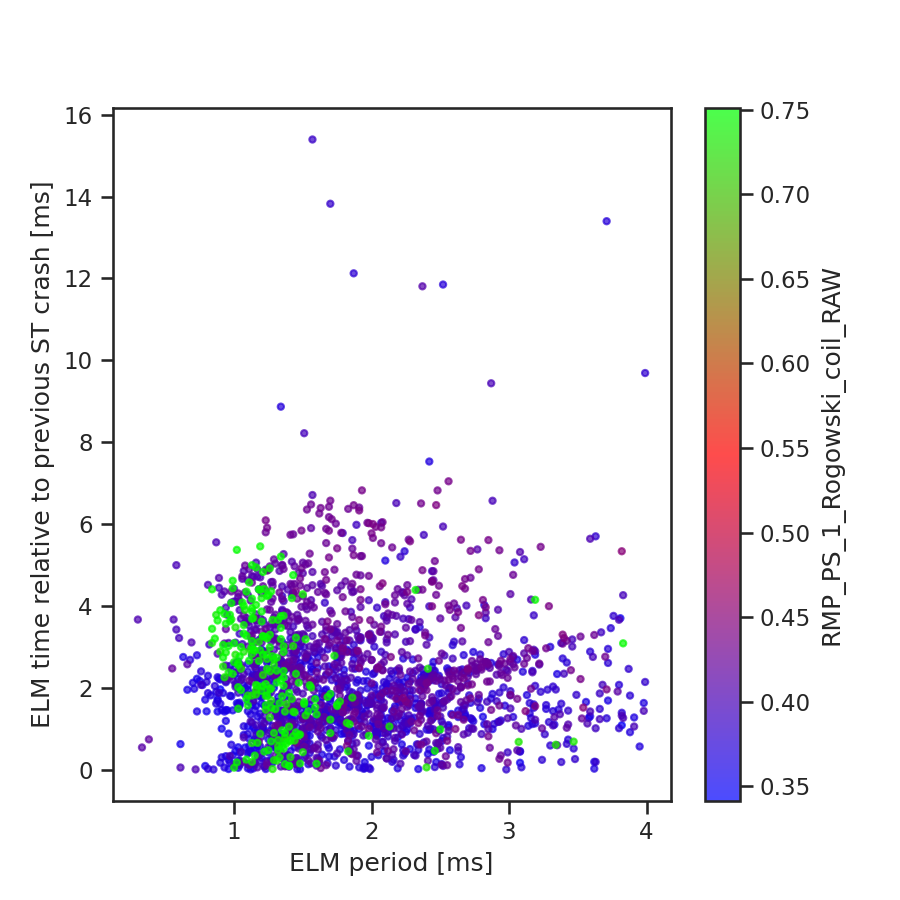

In [42]:
RMP_tot=np.empty(0)
RMP_totx=np.empty(0)

ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)
triangularity_val=np.empty(0)


for i, d in enumerate(pedestal_data_list):
    
    # if d.shot_number in  range(18350,24000): 
    #     continue
    

    # if 18400<d.shot_number<20151:
    #     continue

    # if 20154<d.shot_number<20180:
    #     continue

    # if 18230<d.shot_number<18250:
    #     continue

    # if d.shot_number in [18252, 18255,18257,18260,18267,18273,18274,18275, 18276,18277,18278,18279,18347, 18360, 18350,21657 ]:
    #     continue


    # if 20199<d.shot_number<28800:
    #     continue

    # if 182<d.shot_number<20180:
    #     continue

    # if d.shot_number in [18252, 18255,18257,18260,18267,18273,18274,18275, 18276,18277,18278,18279 ]:
    #     continue
    
    #print(d.shot_number)

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']

    RMP=shot(name="RMP_PS_1_Rogowski_coil_RAW")

    triang_closest_times = t_ELM_start[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    triang_closest_times_ints = triang_closest_times.astype(int)
    interpolated_tria_values = triangularity.interp(time=triang_closest_times_ints)
    
    interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)

        
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)

    

    RMP_tot = np.concatenate((RMP_tot,  interpolated_RMP_tot.to_numpy()[mask2]))
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))
    triangularity_val = np.concatenate((triangularity_val, interpolated_tria_values.to_numpy()[mask2]))

    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6),dpi=150)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for afrom core.ELM_extraction import ELM_phase square plot.
#gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
#                      left=0.1, right=0.9, bottom=0.1, top=0.9,
#                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot()
plt.xlabel('ELM period [ms]')
plt.ylabel('ELM time relative to previous ST crash [ms]')
# Draw the scatter plot and marginals.
sorting_criterion = triangularity_val

# Sort the data based on the sorting criterion
sorted_indices = np.argsort(sorting_criterion)
sorted_ELM_duration_tot = ELM_duration_tot[sorted_indices]
sorted_ELM_ST_time_tot = ELM_ST_time_tot[sorted_indices]
sorted_triangularity_val = triangularity_val[sorted_indices]


# sorting_criterion = RMP_tot
# sorted_indices = np.argsort(sorting_criterion)
# sorted_ELM_duration_tot = ELM_duration_tot[sorted_indices]
# sorted_ELM_ST_time_tot = ELM_ST_time_tot[sorted_indices]
# sorted_RMP_tot = RMP_tot[sorted_indices]


scatter=ax.scatter(sorted_ELM_duration_tot, sorted_ELM_ST_time_tot,s=9,c=sorted_triangularity_val, alpha=0.7,marker="o", cmap='brg')
#normalize = Normalize(vmin=min(sorted_RMP_tot), vmax=max(sorted_RMP_tot))

#scatter=ax.scatter(sorted_ELM_duration_tot, sorted_ELM_ST_time_tot,s=9,c=sorted_RMP_tot, alpha=0.4 ,marker="o", cmap='brg',vmin=-4000)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'$\dfrac{\delta_u+\delta_l}{2}$')
#cbar.set_label(r'RMP_PS_1_Rogowski_coil_RAW')

18275
19921
18274
18278
19922
18276
18273
18277
19923


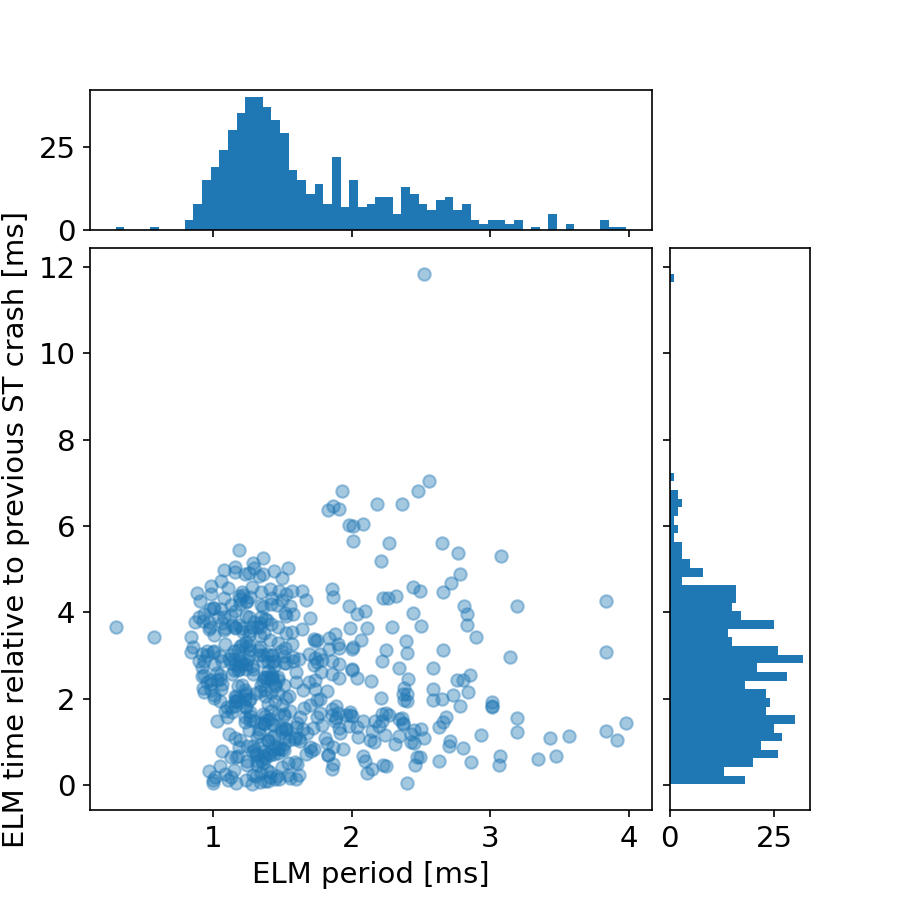

In [ ]:
ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
    # if d.shot_number in  range(18350,24000): 
    #     continue


    if 18278<d.shot_number<19921:
        continue

    if 182<d.shot_number<18273:
        continue

    if 19924<d.shot_number<200000:
        continue
    print(d.shot_number)

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)
    
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6),dpi=150)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for afrom core.ELM_extraction import ELM_phase square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ELM period [ms]')
plt.ylabel('ELM time relative to previous ST crash [ms]')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ELM_duration_tot, ELM_ST_time_tot, ax, ax_histx, ax_histy)


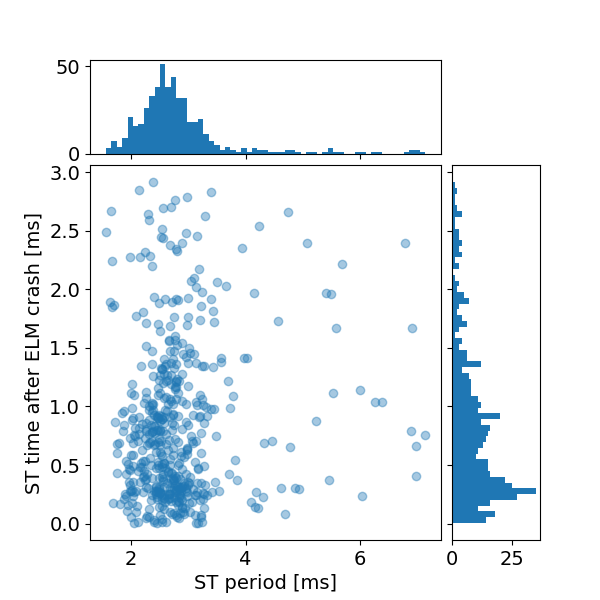

In [227]:
ST_delay_after_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    if 18400<d.shot_number<20151:
        continue

    if 20154<d.shot_number<20180:
        continue

    if 18230<d.shot_number<18250:
        continue

    if d.shot_number in [18252, 18255,18257,18260,18267,18273,18274,18275, 18276,18277,18278,18279,18347, 18360, 18350,21657 ]:
        continue



    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_ELM_phases, ST_delay_after_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times)
    ST_periods = np.diff(ST_times)
    ST_delay_after_ELM = ST_delay_after_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_delay_after_ELM_tot = np.concatenate((ST_delay_after_ELM_tot, ST_delay_after_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6),dpi=100)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time after ELM crash [ms]')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_delay_after_ELM_tot, ax, ax_histx, ax_histy)

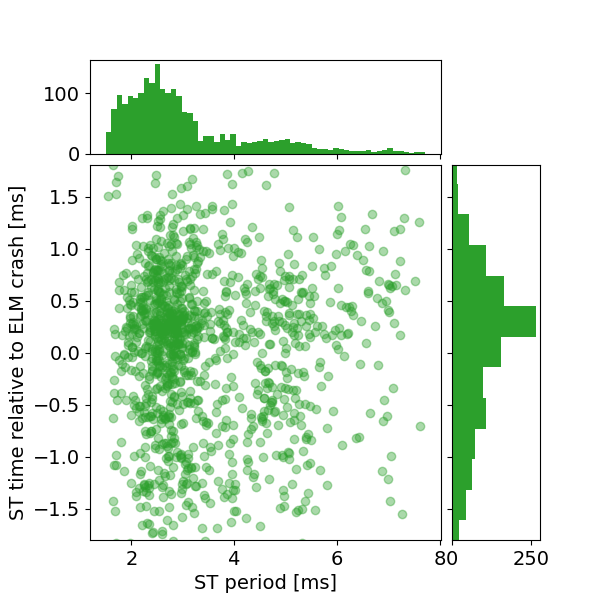

In [ ]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c='C2')

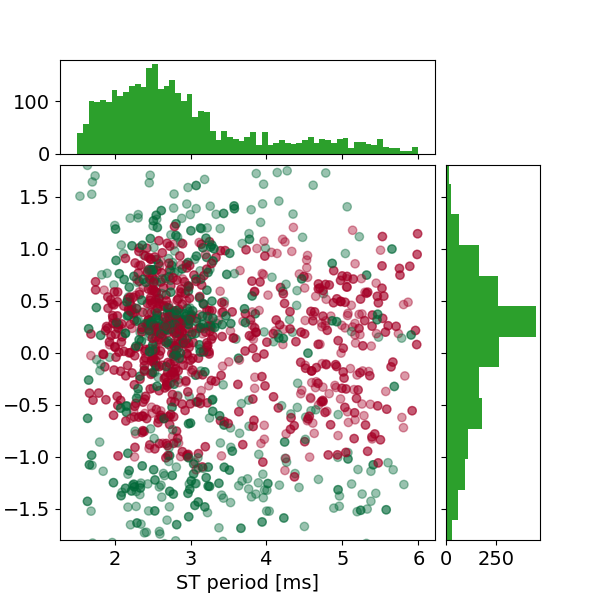

In [ ]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask2 = np.logical_and(0. < ST_periods, ST_periods < 6.)
    #mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)
    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c=elm_duration_tot, cmap='RdYlGn')

ValueError: x and y must be the same size

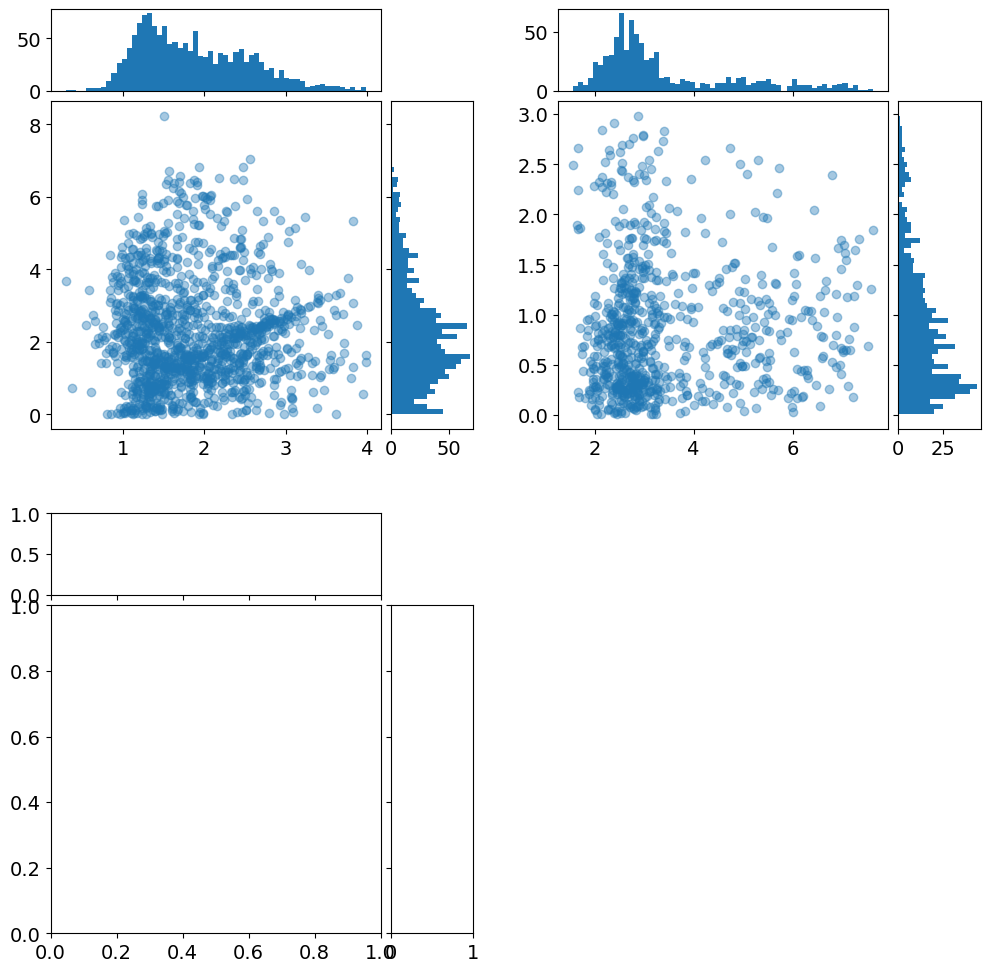

In [ ]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask2 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)


ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))



ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)
    
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))


ST_delay_after_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_ELM_phases, ST_delay_after_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times)
    ST_periods = np.diff(ST_times)
    ST_delay_after_ELM = ST_delay_after_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_delay_after_ELM_tot = np.concatenate((ST_delay_after_ELM_tot, ST_delay_after_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))




import matplotlib.pyplot as plt

# Sample data for each subplot (replace with your actual data)
data_subplots = [
    {'ELM_duration': ELM_duration_tot, 'ELM_ST_time': ELM_ST_time_tot},
    {'ELM_duration': ST_periods_tot, 'ELM_ST_time': ST_delay_after_ELM_tot},
    {'ELM_duration': ST_periods_tot, 'ELM_ST_time': ST_time_relative_to_ELM_tot},
    {'ELM_duration': [7, 8, 9, 10, 11], 'ELM_ST_time': [8, 9, 10, 11, 12]}
]

# Create the main figure
fig = plt.figure(figsize=(12, 12))

# Outer gridspec with two rows and two columns
outer_gs = fig.add_gridspec(2, 2, width_ratios=(1, 1), height_ratios=(1, 1), wspace=0.2, hspace=0.2)

for i in range(2):
    for j in range(2):
        # Inner gridspec for each subplot
        inner_gs = outer_gs[i, j].subgridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                                              wspace=0.05, hspace=0.05)

        # Get the data for the current subplot
        subplot_data = data_subplots[i * 2 + j]

        # Create the Axes for the current subplot
        ax = fig.add_subplot(inner_gs[1, 0])
        ax_histx = fig.add_subplot(inner_gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(inner_gs[1, 1], sharey=ax)

        # Draw the scatter plot and marginals using the current subplot's data
        scatter_hist(subplot_data['ELM_duration'], subplot_data['ELM_ST_time'], ax, ax_histx, ax_histy)

plt.show()

